## Ta model ima podane rešitve v podatkih

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from foursquareAPI import get_poi
import math
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf

In [2]:
df = pd.read_csv("Parkirisca_do_10_05_2022.csv")
df["Zasedenost"] = df["Kapaciteta"] - df["Prosta mesta"]
df['date'] = pd.to_datetime(df["Datum"], unit="s")
df = df.drop(["Datum", "Prosta (narocniki)", "Oddana (narocniki)",
             "Na voljo (narocniki)", "Cakalna vrsta (narocniki)"], axis=1)
df

,Parkirisce,Prosta mesta,Kapaciteta,Zasedenost,date
0,Bezigrad,58,64,6,2022-02-24 19:13:21
1,Center Stozice,142,509,367,2022-02-24 19:13:21
2,Dolenjska cesta (Strelisce),50,67,17,2022-02-24 19:13:21
3,Gosarjeva ulica,16,190,174,2022-02-24 19:13:21
4,Gosarjeva ulica II.,121,115,-6,2022-02-24 19:13:21
...,...,...,...,...,...
292887,SRC Stozice,0,0,0,2022-05-10 06:05:38
292888,Tacen,0,0,0,2022-05-10 06:05:38
292889,Bratislavska,0,0,0,2022-05-10 06:05:38
292890,BS4/ I,63,80,17,2022-05-10 06:05:38


In [3]:
def copy_and_impute(parking):
    # Prepare new data frame, which will be synced (freqeuncy is exactly 10 mins)
    parking_sync = parking.asfreq("10 min")

    # Copy data before hole 1
    hole_start_date1 = pd.to_datetime("2022-03-15 08:25:12", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iterrows()):
        if index > hole_start_date1:
            break
        row_sync["Zasedenost"] = row["Zasedenost"]

    # Impute first hole
    hole_end_date1 = pd.to_datetime("2022-03-23 07:02:59", format='%Y-%m-%d %H:%M:%S')
    num_rows_imputed = 0
    for index_sync, row_sync in parking_sync.iterrows():
        if index_sync <= hole_start_date1:
            continue
        if index_sync >= hole_end_date1:
            break
        # Repeat data from previous week day
        row_sync["Zasedenost"] = parking_sync[parking_sync.index ==
                                              index_sync - pd.to_timedelta(1, unit="W")]["Zasedenost"][0]
        num_rows_imputed += 1

    # Copy data after hole 1, before hole 2
    hole_start_date2 = pd.to_datetime("2022-04-07 22:10:55", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iloc[num_rows_imputed:].iterrows()):
        if index < hole_end_date1:
            continue
        if index >= hole_start_date2:
            break
        row_sync["Zasedenost"] = row["Zasedenost"]

    # Impute second hole
    hole_end_date2 = pd.to_datetime("2022-04-22 08:11:54", format='%Y-%m-%d %H:%M:%S')
    for index_sync, row_sync in parking_sync.iterrows():
        if index_sync <= hole_start_date2:
            continue
        if index_sync > hole_end_date2:
            break
        # Repeat data from previous week day
        row_sync["Zasedenost"] = parking_sync[parking_sync.index ==
                                              index_sync - pd.to_timedelta(1, unit="W")]["Zasedenost"][0]
        num_rows_imputed += 1

    # Copy the remaning data
    hole_start_date2 = pd.to_datetime("2022-04-07 22:10:55", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iloc[num_rows_imputed:].iterrows()):
        if index < hole_end_date2:
            continue
        row_sync["Zasedenost"] = row["Zasedenost"]

    parking_sync = parking_sync["Zasedenost"].fillna(method="bfill")  # Fill remaning spaces with previous values
    parking_sync.dropna(axis=0, inplace=True)  # Remove the somehow remaning NaN rows

    return parking_sync

In [4]:
parkings = {}
for name, group in df.groupby("Parkirisce"):
    name = str(name)
    parking = group

    parking = parking.set_index('date')
    parking = parking.drop(["Parkirisce", "Prosta mesta"], axis=1)

    capacity = 0
    for _, row in parking.iterrows():
        if row["Kapaciteta"] != 0:
            capacity = row["Kapaciteta"]
            break

    raidus = 50
    points_of_interest = get_poi(name, radius=raidus)

    # Filter empty data (10 parkings)
    if (parking["Zasedenost"] == 0).all() or (parking["Zasedenost"] == capacity).all() or points_of_interest is None:
        continue

    parking_sync = pd.DataFrame(copy_and_impute(parking))
    parking_sync["Kapaciteta"] = [capacity for _ in range(len(parking_sync.index))]
    parking_sync["Procent_zasedenosti"] = parking_sync["Zasedenost"] / parking_sync["Kapaciteta"]

    # Add points of interest to the specific column (0: not present, radius-distance: point of interest score) -> POIs are weighted
    restaurant_dist = []
    art_dist = []
    coffee_dist = []
    bar_dist = []
    for distance, poi in points_of_interest:
        if "Restaurant" in poi:
            restaurant_dist.append(distance)
        elif "Art" in poi or "Museum" in poi:
            art_dist.append(distance)
        elif "Coffee" in poi or "Café" in poi or "Cafeteria" in poi:
            coffee_dist.append(distance)
        elif "Bar" in poi:
            bar_dist.append(distance)
    
    restaurant_score = 0 if not restaurant_dist else raidus + 1 - sum(restaurant_dist) / len(restaurant_dist)
    art_score = 0 if not art_dist else raidus + 1 - sum(art_dist) / len(art_dist)
    coffee_score = 0 if not coffee_dist else raidus + 1 - sum(coffee_dist) / len(coffee_dist)
    bar_score = 0 if not bar_dist else raidus + 1 - sum(bar_dist) / len(bar_dist)
    
    parking_sync["Restaurant_score"] = [restaurant_score for _ in range(len(parking_sync.index))]
    parking_sync["Art_score"] = [art_score for _ in range(len(parking_sync.index))]
    parking_sync["Coffee_score"] = [coffee_score for _ in range(len(parking_sync.index))]
    parking_sync["Bar_score"] = [bar_score for _ in range(len(parking_sync.index))]

    parking_sync = parking_sync.astype({"Zasedenost": int, "Kapaciteta": int, "Procent_zasedenosti": float,
                                               "Restaurant_score": float,	"Art_score": float,	"Coffee_score": float,	"Bar_score": float})

    parkings[name] = parking_sync  # Save the synced data frame to dict

print(parkings)

{'BS4/ I':                      Zasedenost  Kapaciteta  Procent_zasedenosti  \
date                                                               
2022-03-04 09:31:53           0          80               0.0000   
2022-03-04 09:41:53           0          80               0.0000   
2022-03-04 09:51:53           0          80               0.0000   
2022-03-04 10:01:53           0          80               0.0000   
2022-03-04 10:11:53           0          80               0.0000   
...                         ...         ...                  ...   
2022-05-10 03:51:53          17          80               0.2125   
2022-05-10 04:01:53          16          80               0.2000   
2022-05-10 04:11:53          15          80               0.1875   
2022-05-10 04:21:53          16          80               0.2000   
2022-05-10 04:31:53          17          80               0.2125   

                     Restaurant_score  Art_score  Coffee_score  Bar_score  
date                        

In [5]:
parkings["BS4/ I"].dtypes

Zasedenost               int32
Kapaciteta               int32
Procent_zasedenosti    float64
Restaurant_score       float64
Art_score              float64
Coffee_score           float64
Bar_score              float64
dtype: object

In [6]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        dataX.append(dataset[i:(i+look_back), :])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

6413/6413 - 20s - loss: 0.0037 - 20s/epoch - 3ms/step
Test Score: 0.02 RMSE


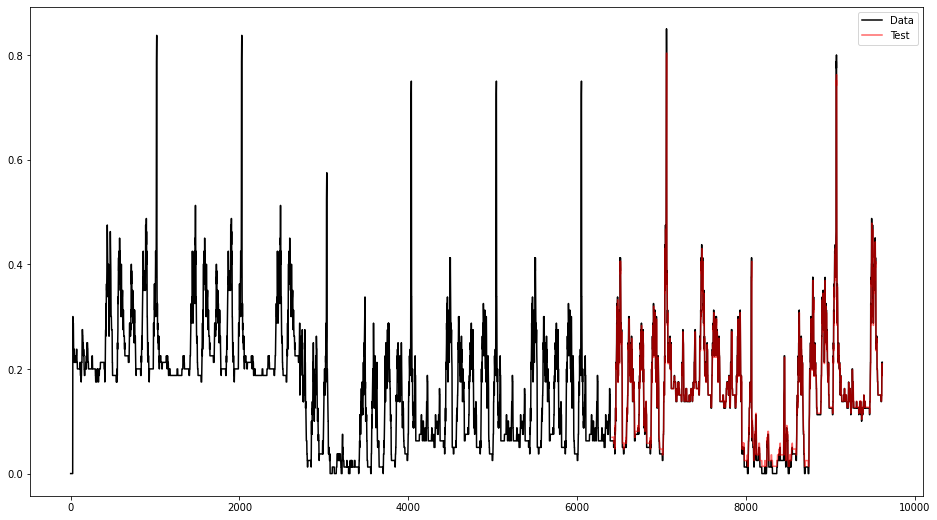

6413/6413 - 21s - loss: 0.0237 - 21s/epoch - 3ms/step
Test Score: 0.02 RMSE


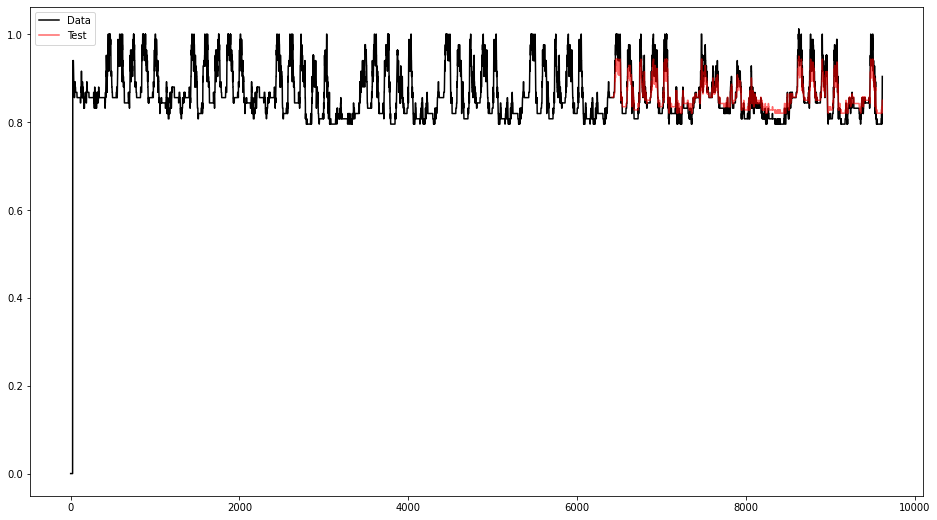

7146/7146 - 20s - loss: 0.0075 - 20s/epoch - 3ms/step
Test Score: 0.03 RMSE


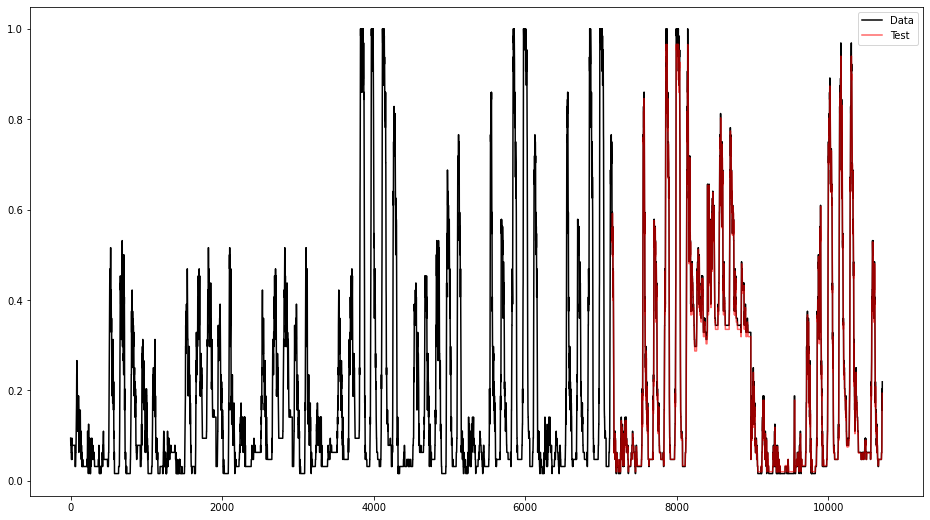

7146/7146 - 17s - loss: 0.0035 - 17s/epoch - 2ms/step
Test Score: 0.03 RMSE


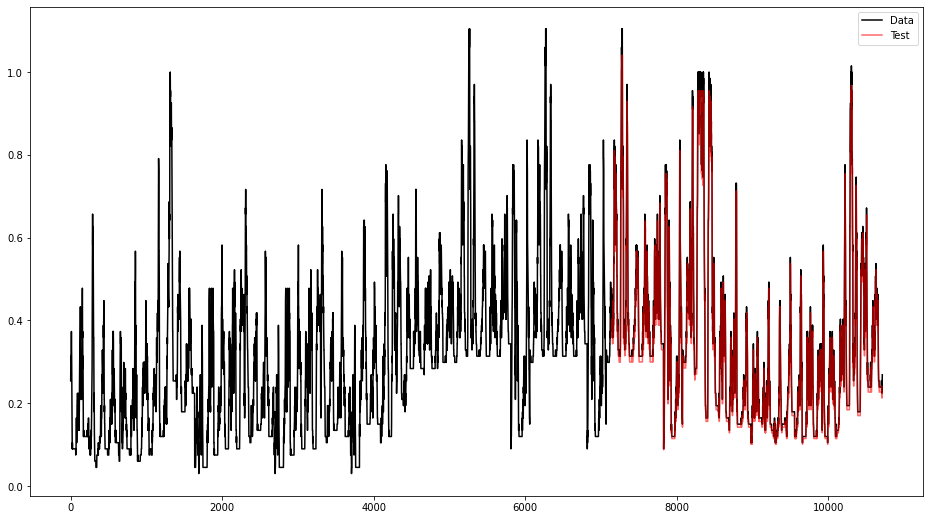

7146/7146 - 18s - loss: 0.0191 - 18s/epoch - 2ms/step
Test Score: 0.01 RMSE


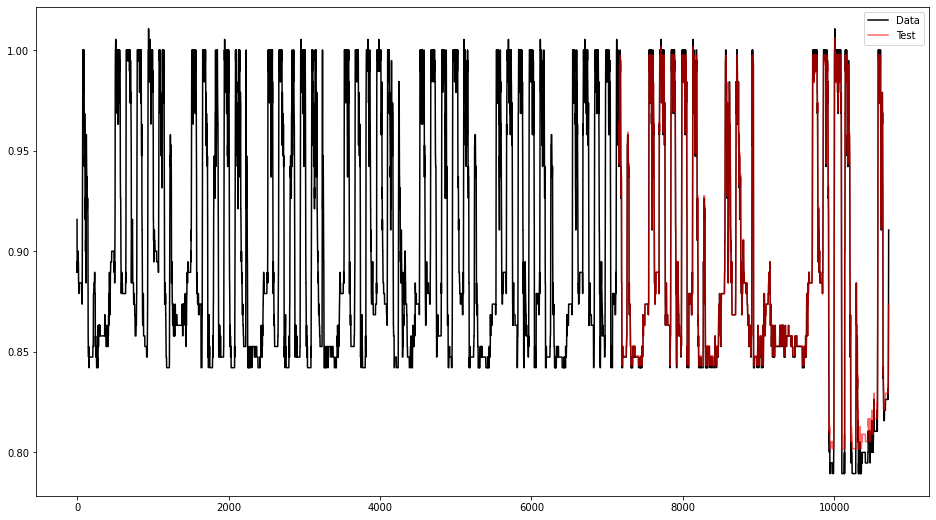

7146/7146 - 17s - loss: 0.0052 - 17s/epoch - 2ms/step
Test Score: 0.01 RMSE


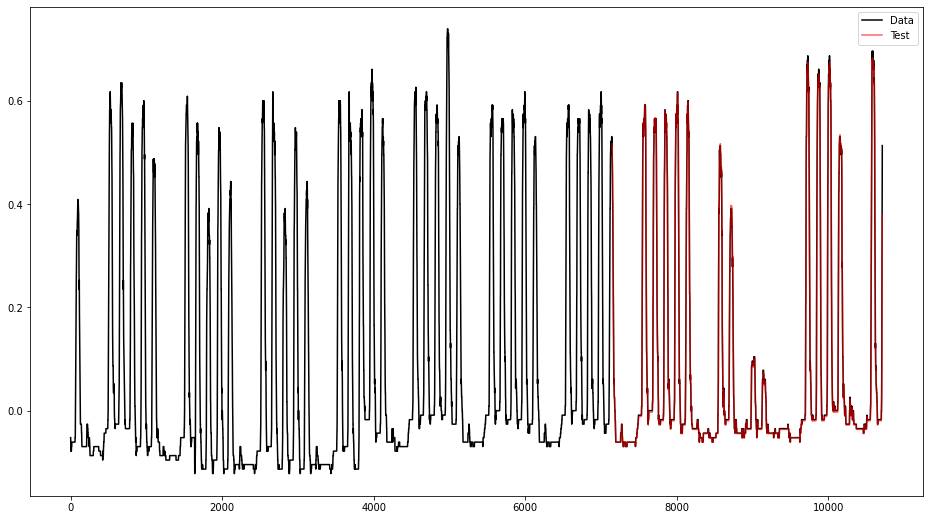

7146/7146 - 17s - loss: 0.0024 - 17s/epoch - 2ms/step
Test Score: 0.02 RMSE


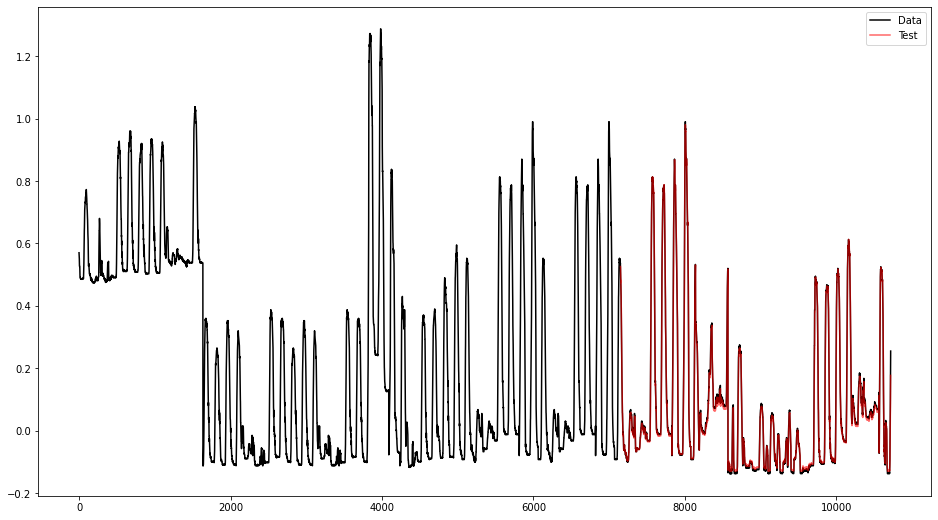

7146/7146 - 18s - loss: 0.0153 - 18s/epoch - 2ms/step
Test Score: 0.02 RMSE


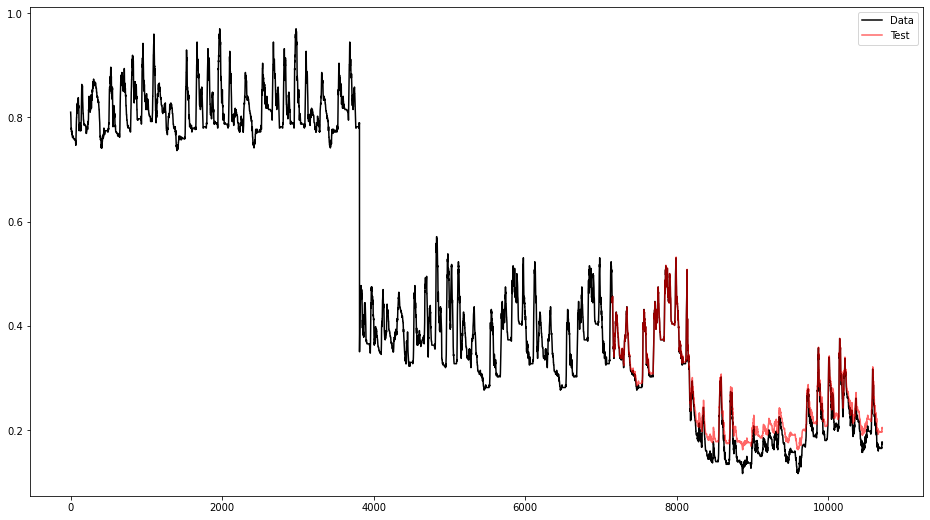

7146/7146 - 17s - loss: 0.0046 - 17s/epoch - 2ms/step
Test Score: 0.02 RMSE


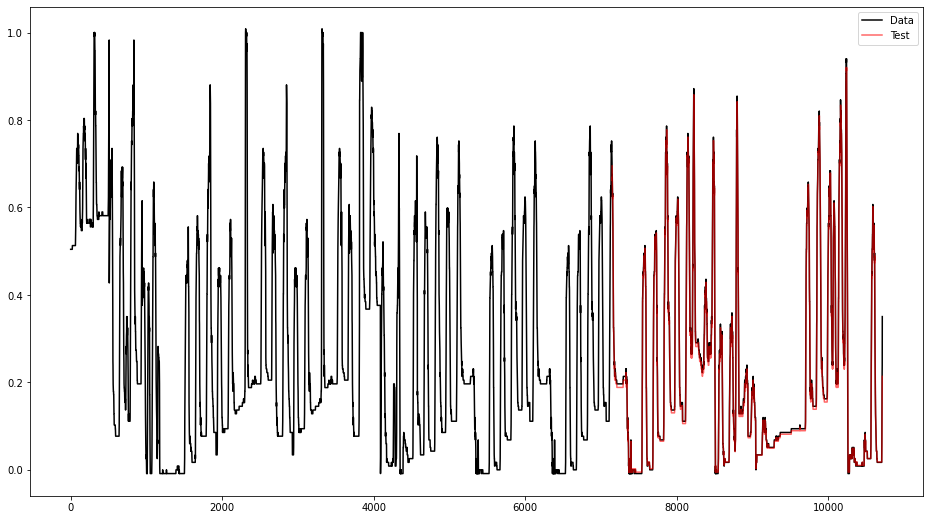

7146/7146 - 17s - loss: 0.0084 - 17s/epoch - 2ms/step
Test Score: 0.03 RMSE


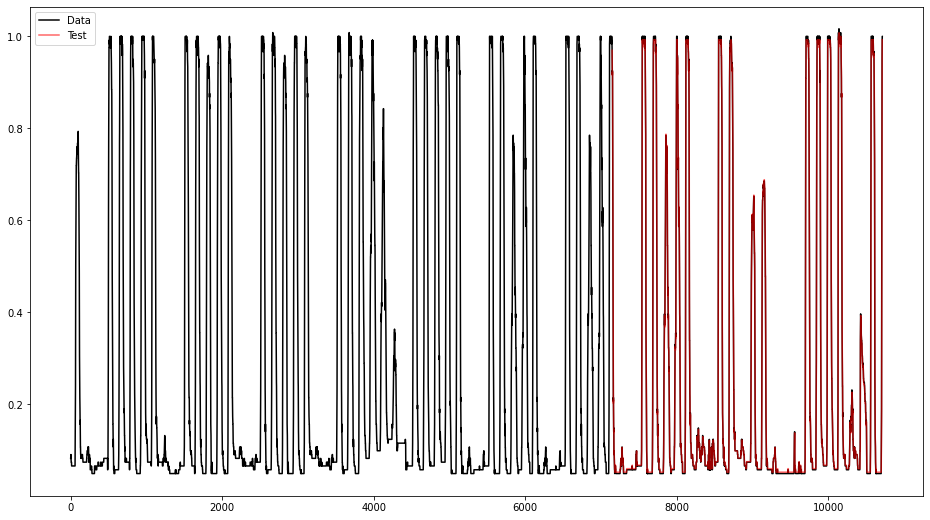

7146/7146 - 18s - loss: 0.0049 - 18s/epoch - 2ms/step
Test Score: 0.02 RMSE


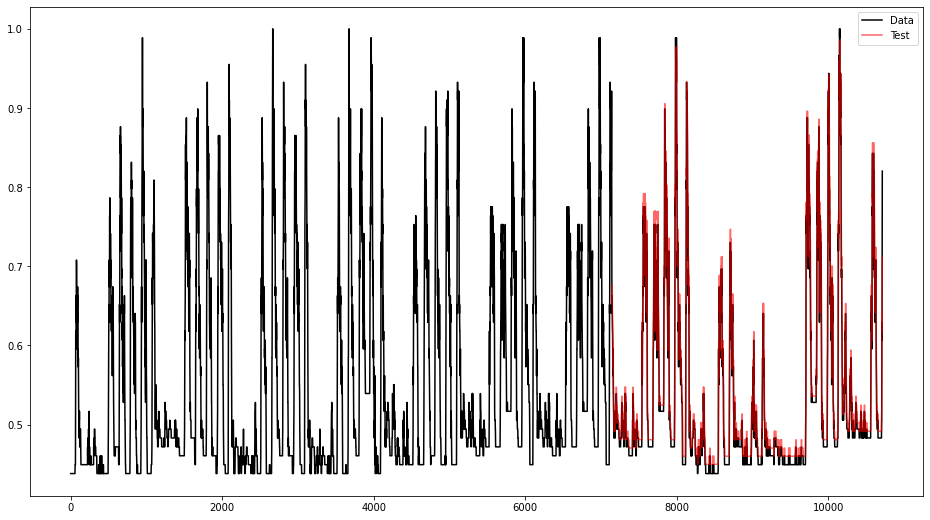

7146/7146 - 17s - loss: 0.0048 - 17s/epoch - 2ms/step
Test Score: 0.02 RMSE


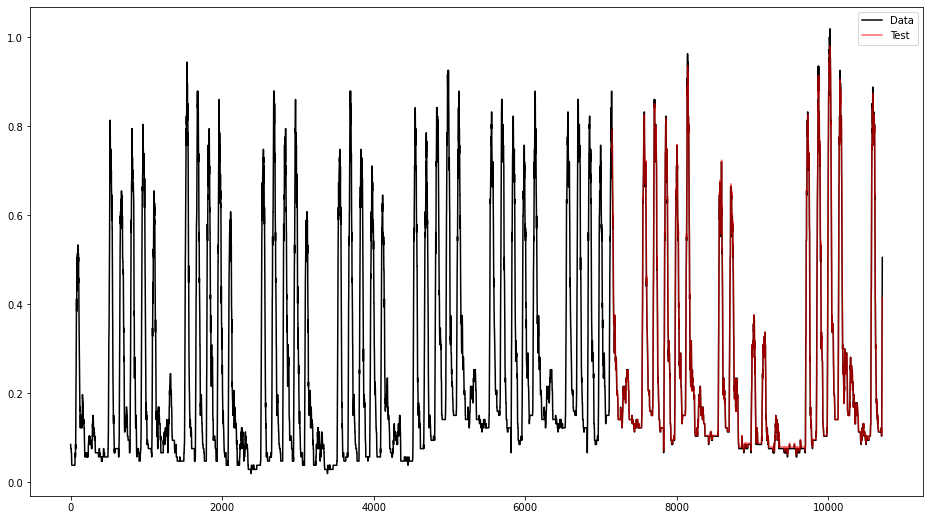

7146/7146 - 17s - loss: 0.0274 - 17s/epoch - 2ms/step
Test Score: 0.02 RMSE


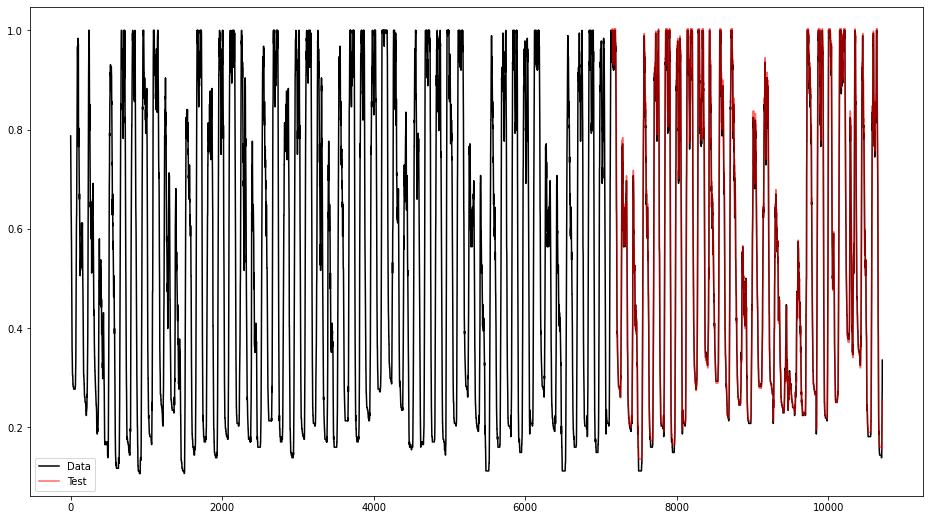

7146/7146 - 18s - loss: 0.0096 - 18s/epoch - 3ms/step
Test Score: 0.01 RMSE


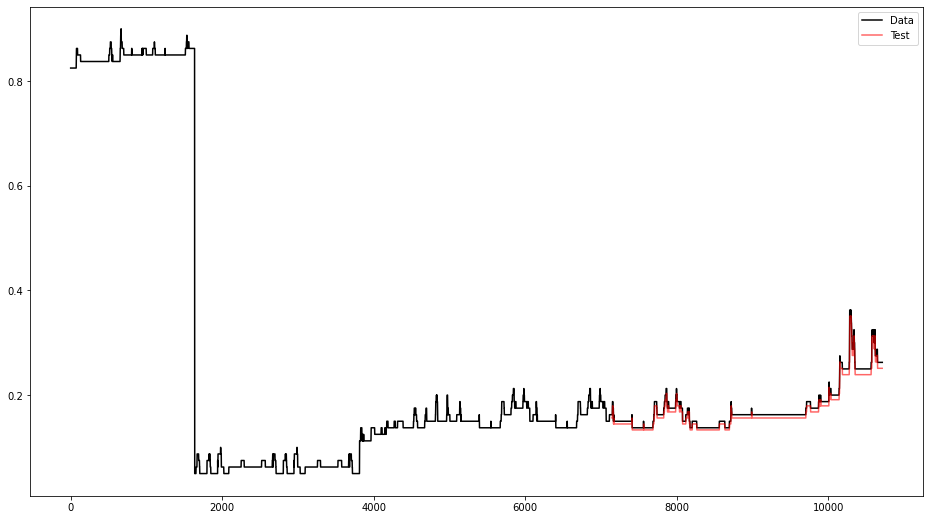

7146/7146 - 17s - loss: 0.0067 - 17s/epoch - 2ms/step
Test Score: 0.01 RMSE


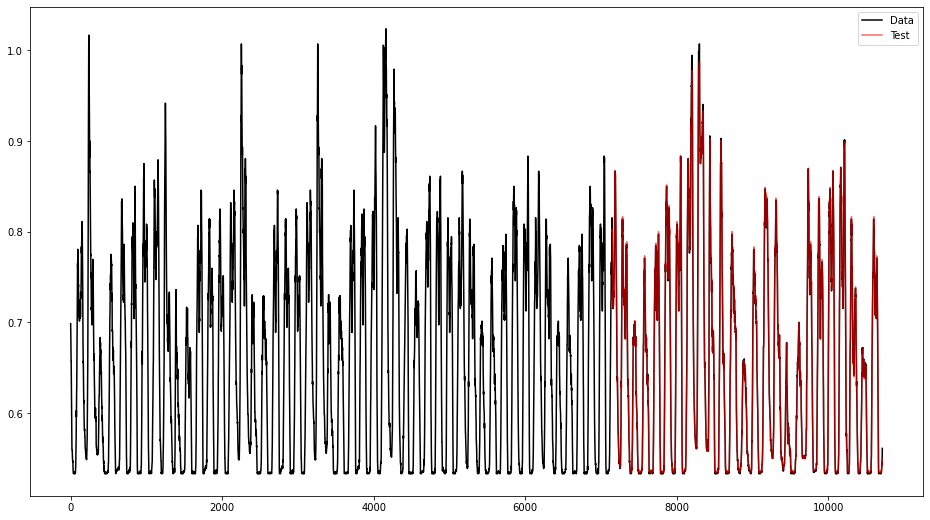

7146/7146 - 17s - loss: 0.0065 - 17s/epoch - 2ms/step
Test Score: 0.03 RMSE


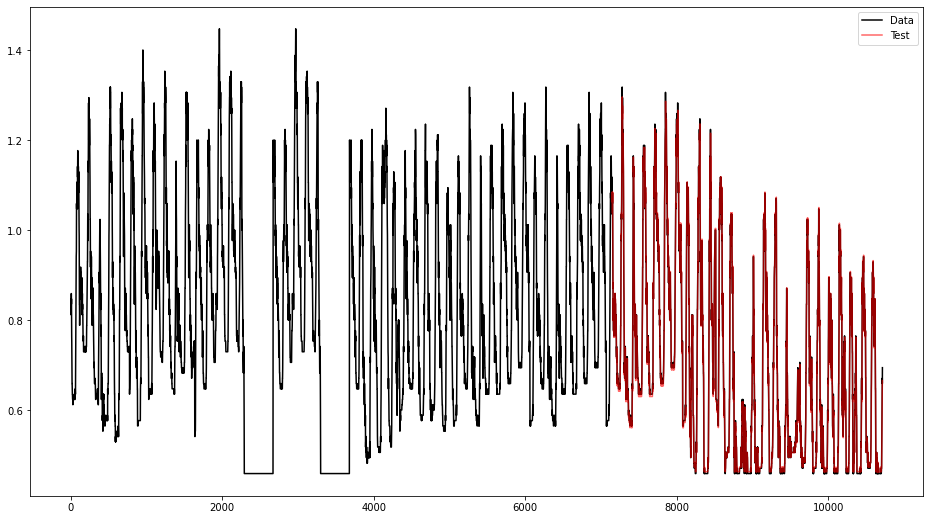

7146/7146 - 16s - loss: 0.0079 - 16s/epoch - 2ms/step
Test Score: 0.04 RMSE


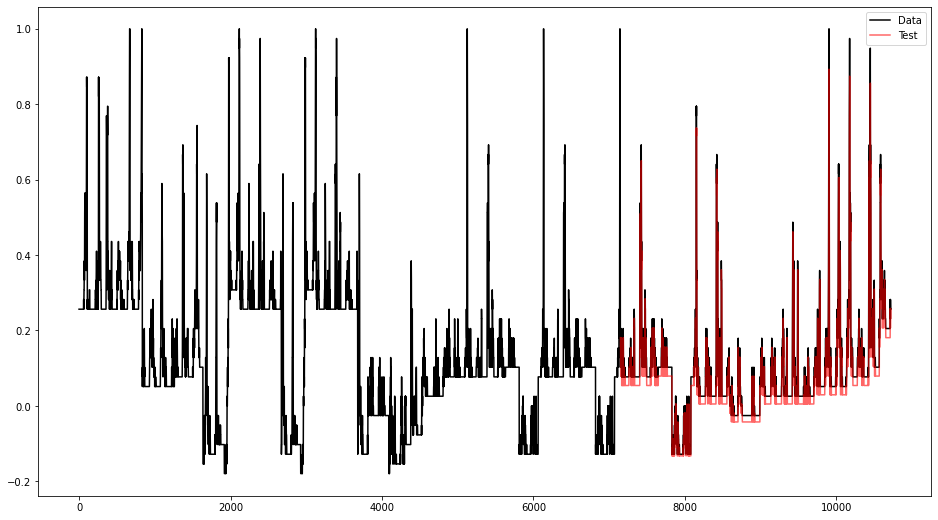

7146/7146 - 16s - loss: 0.0063 - 16s/epoch - 2ms/step
Test Score: 0.02 RMSE


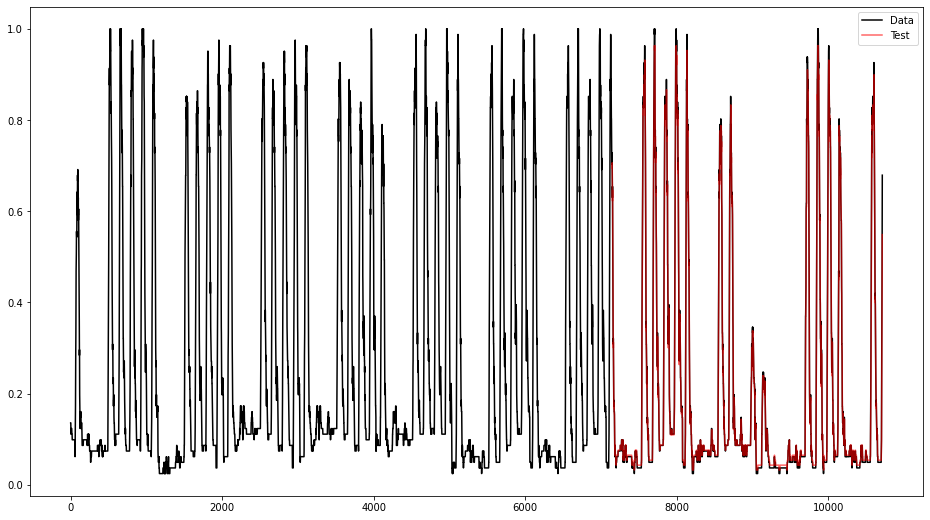

7146/7146 - 16s - loss: 0.0156 - 16s/epoch - 2ms/step
Test Score: 0.05 RMSE


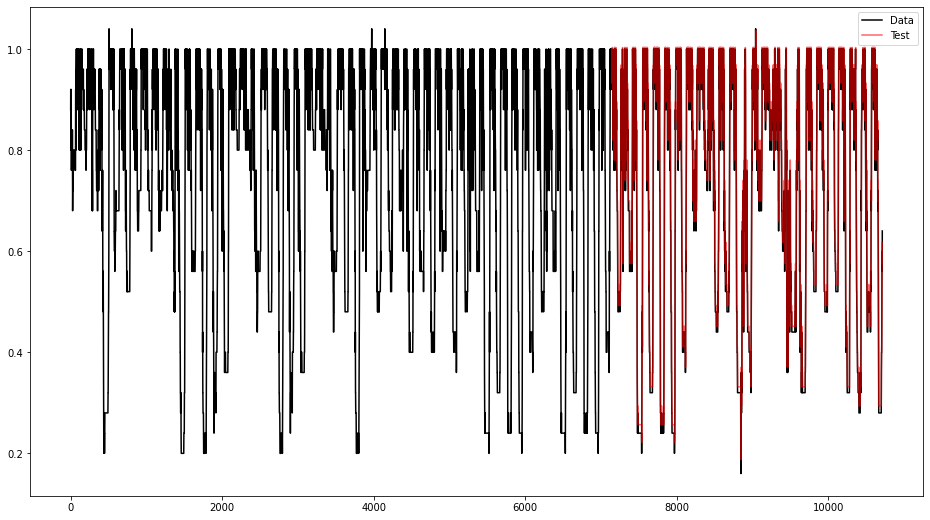

7146/7146 - 16s - loss: 0.0158 - 16s/epoch - 2ms/step
Test Score: 0.00 RMSE


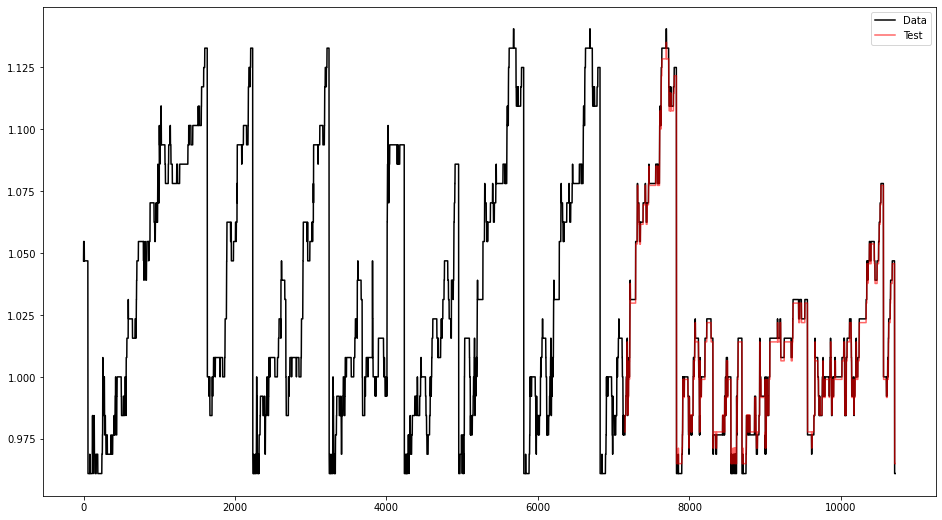

7146/7146 - 16s - loss: 0.0083 - 16s/epoch - 2ms/step
Test Score: 0.02 RMSE


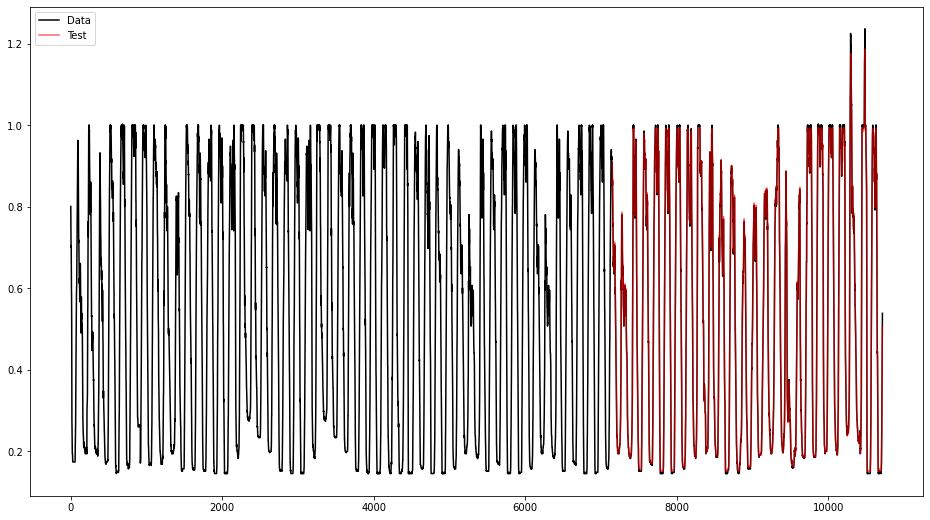

7146/7146 - 16s - loss: 0.0089 - 16s/epoch - 2ms/step
Test Score: 0.03 RMSE


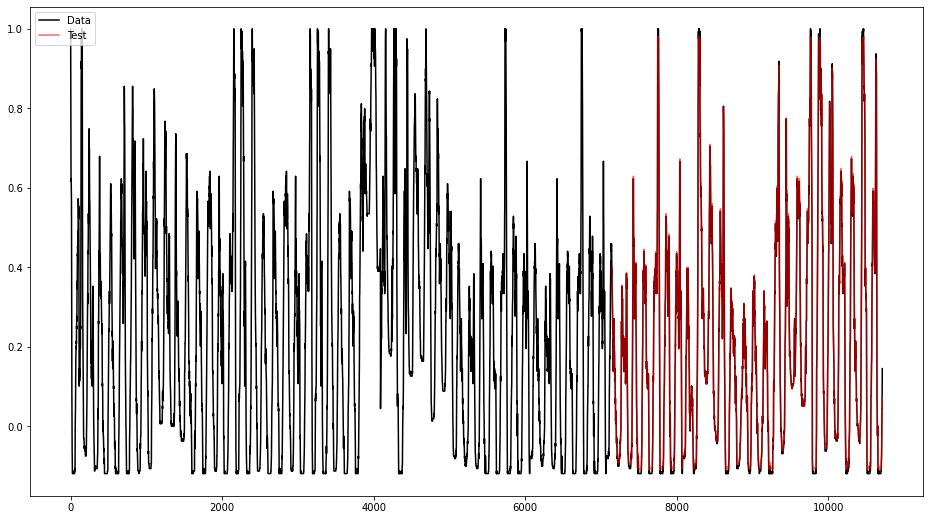

7146/7146 - 16s - loss: 0.0010 - 16s/epoch - 2ms/step
Test Score: 0.14 RMSE


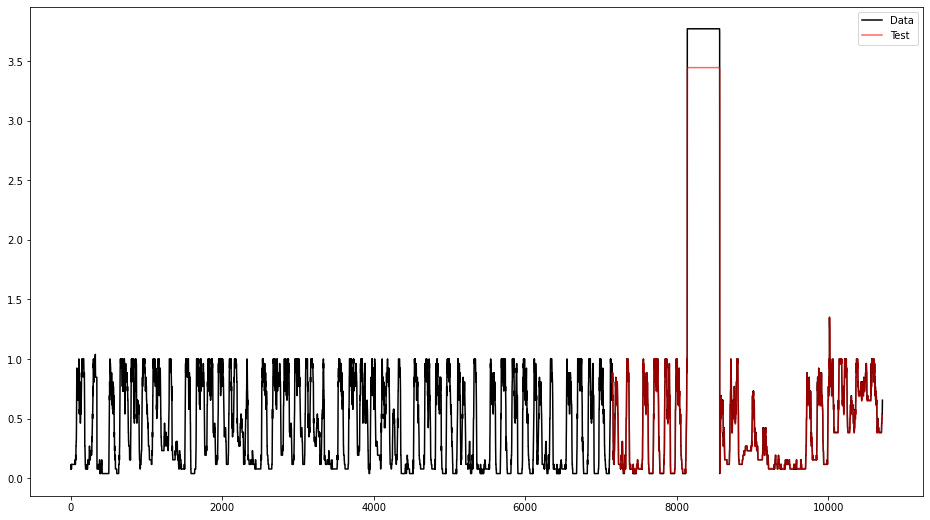

7146/7146 - 16s - loss: 0.0162 - 16s/epoch - 2ms/step
Test Score: 0.04 RMSE


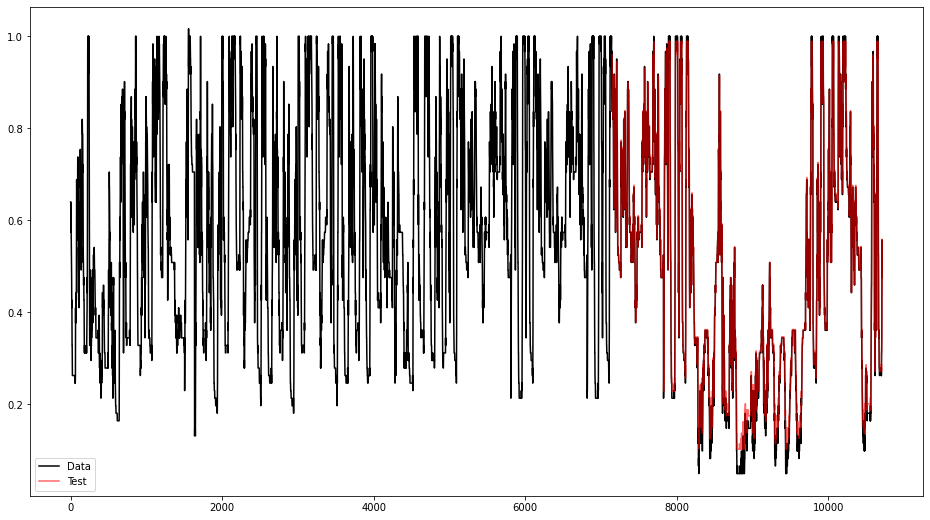

7146/7146 - 16s - loss: 0.0043 - 16s/epoch - 2ms/step
Test Score: 0.03 RMSE


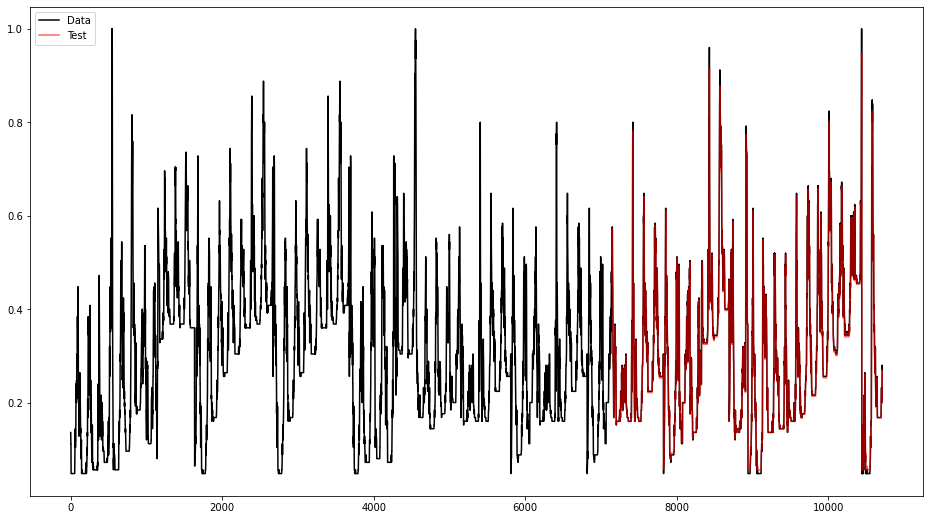

7146/7146 - 16s - loss: 0.0066 - 16s/epoch - 2ms/step
Test Score: 0.03 RMSE


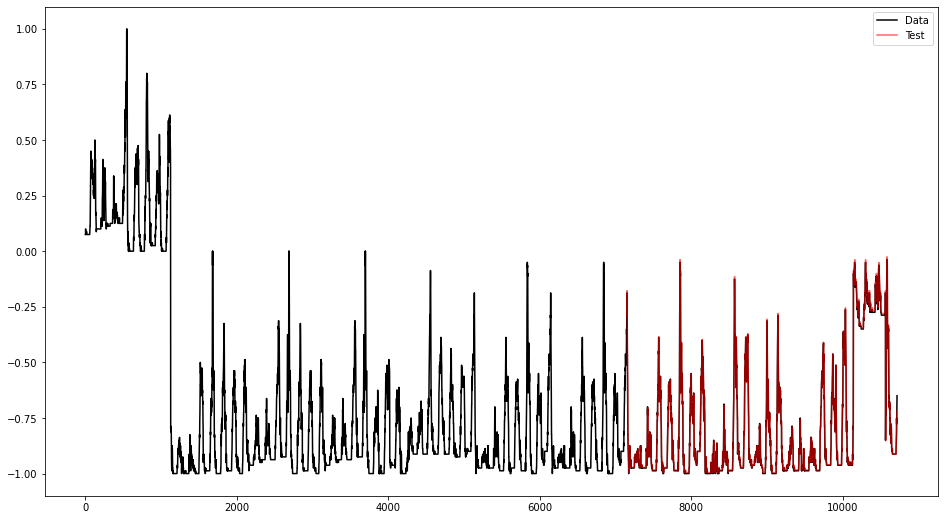

7146/7146 - 14s - loss: 0.0058 - 14s/epoch - 2ms/step
Test Score: 0.02 RMSE


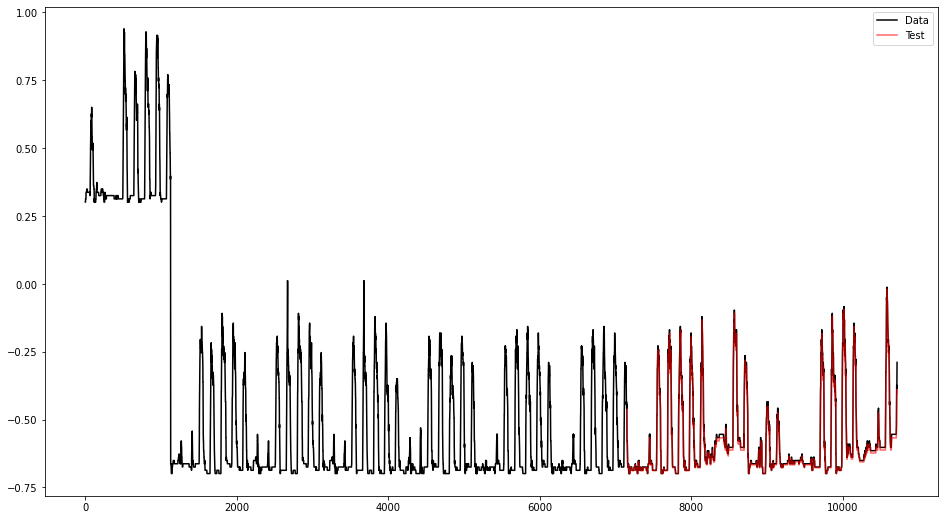

7146/7146 - 13s - loss: 0.0040 - 13s/epoch - 2ms/step
Test Score: 0.02 RMSE


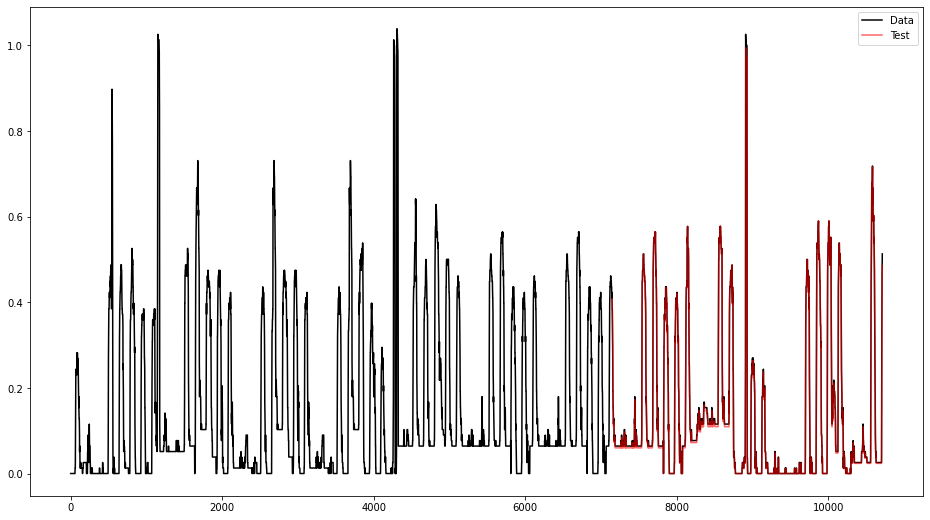

7146/7146 - 13s - loss: 0.0030 - 13s/epoch - 2ms/step
Test Score: 0.06 RMSE


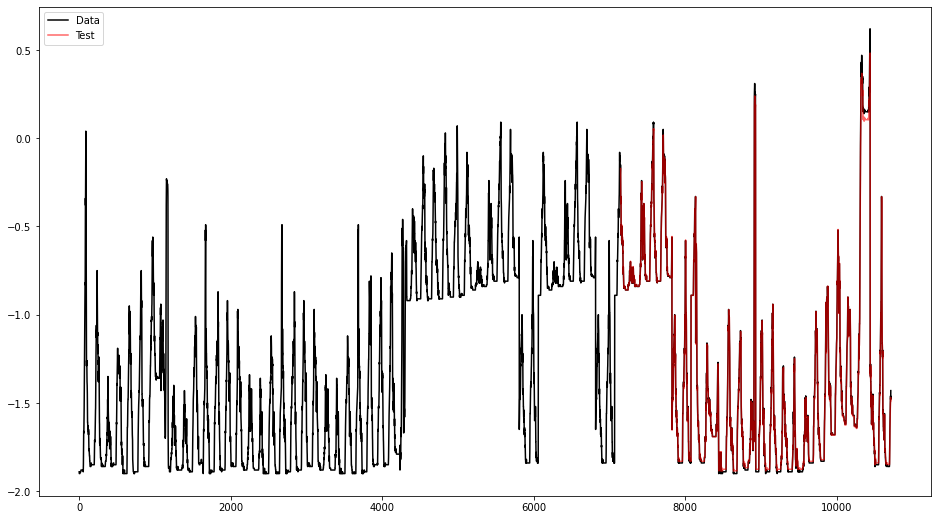

In [7]:
look_back = 1
for parking_name, parking_df in parkings.items():
    # plt.figure(figsize=(16, 9))
    # plt.plot(parking_df["Procent_zasedenosti"])
    # plt.show()

    scalerX = MinMaxScaler(feature_range=(0, 1))
    scalerY = MinMaxScaler(feature_range=(0, 1))
    datasetX = scalerX.fit_transform(
        parking_df[["Procent_zasedenosti", "Restaurant_score", "Art_score", "Coffee_score", "Bar_score"]])
    datasetY = scalerY.fit_transform(parking_df[["Procent_zasedenosti"]])

    # split into train and test sets
    train_size = int(len(datasetX) * 0.667)
    train, test = datasetX[: train_size, :], datasetX[train_size:, :]
    # print(len(train), len(test))

    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, trainX.shape[-1])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2) # Long
    model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)  # Short

    # Save/Load
    model_path = "models/" + parking_name.replace("/", "_") + ".h5"
    model.save(model_path)
    # model = load_model(model_path)

    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # invert predictions
    testPredict = scalerY.inverse_transform(testPredict)
    testY = scalerY.inverse_transform([testY])

    # calculate root mean squared error
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
    print('Test Score: %.2f RMSE' % (testScore))

    # offset test predictions for plotting
    testPredictPlot = np.empty_like(datasetY)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(datasetY)-1, :] = testPredict

    # plot baseline and predictions
    plt.figure(figsize=(16, 9))
    plt.plot(scalerY.inverse_transform(datasetY), "k-", label="Data")
    plt.plot(testPredictPlot, "r-", label="Test", alpha=0.6)
    plt.legend()
    plt.show()
